In [ ]:
import numpy as np
import operator
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.animation import FuncAnimation, PillowWriter

ENVIRONMENT SETUP :

In [ ]:
class GridWorldEnv:
    def __init__(self):
        self.height = 10
        self.width = 10
        self.grid = np.zeros(( self.height, self.width)) - 1
        
        self.agent_locations = [(1, 1), (1, 8), (8, 1), (8, 8)]
        self.walls = [(0, 4), (1, 4), (2, 4), (2, 5), (4, 7), (4, 8), (4, 9), (5, 7), (4, 0), (4, 1), (4, 2), (5, 2), (7, 5), (8, 5), (9, 5), (7, 4)]
        self.targets = [(5, 8), (8, 4), (1, 5), (5, 1)]
        self.agent_colours = ["green","purple","blue","yellow"]
            
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT', 'HALT']
    
    def reset(self) -> list: # resets the environment and returns the agents to their initial positions
        self.agent_locations = [(1, 1), (1, 8), (8, 1), (8, 8)]
        return self.agent_locations
        
    def step(self, actions: list) -> tuple: # takes a step and returns next position and reward
        
        next_positions = []
        rewards = []
        
        for i, (pos, action) in enumerate(zip(self.current_location, actions)):
            next_location = self._compute_next_position(pos, action)
            
            if self._is_valid_move(next_location, next_positions):
                next_positions.append(next_location)
            else :
                next_positions.append(pos)
            
            reward = 0 if next_location == self.targets[i] else -1
            rewards.append(reward)
        
        self.current_positions = next_positions
        done = all([pos == goal for pos, goal in zip(next_positions, self.targets)])
        
        return self.current_positions, rewards
    
    def _compute_next_position(self, pos: tuple, action: int) -> tuple: # whether to move left or right or up or down or halt
        
        x, y = pos
                
        # UP
        if action == 'UP':
            # If agent is at the top, stay still, collect reward
            if last_location[0] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] - 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        # DOWN
        elif action == 'DOWN':
            # If agent is at bottom, stay still, collect reward
            if last_location[0] == self.height - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] + 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        # LEFT
        elif action == 'LEFT':
            # If agent is at the left, stay still, collect reward
            if last_location[1] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] - 1)
                reward = self.get_reward(self.current_location)

        # RIGHT
        elif action == 'RIGHT':
            # If agent is at the right, stay still, collect reward
            if last_location[1] == self.width - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] + 1)
                reward = self.get_reward(self.current_location)

        return reward

    def check_state(self):
        """Check if the agent is in a terminal state (gold or bomb), if so return 'TERMINAL'"""
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

In [3]:
class RandomAgent():        
    # Choose a random action
    def choose_action(self, available_actions):
        """Returns a random choice of the available actions"""
        return np.random.choice(available_actions)   

In [4]:
class Q_Agent():
    # Intialise
    def __init__(self, environment, epsilon=0.05, alpha=0.1, gamma=1):
        self.environment = environment
        self.q_table = dict() # Store all Q-values in dictionary of dictionaries 
        for x in range(environment.height): # Loop through all possible grid spaces, create sub-dictionary for each
            for y in range(environment.width):
                self.q_table[(x,y)] = {'UP':0, 'DOWN':0, 'LEFT':0, 'RIGHT':0} # Populate sub-dictionary with zero values for possible moves

        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        
    def choose_action(self, available_actions):
        """Returns the optimal action from Q-Value table. If multiple optimal actions, chooses random choice.
        Will make an exploratory random action dependent on epsilon."""
        if np.random.uniform(0,1) < self.epsilon:
            action = available_actions[np.random.randint(0, len(available_actions))]
        else:
            q_values_of_state = self.q_table[self.environment.current_location]
            maxValue = max(q_values_of_state.values())
            action = np.random.choice([k for k, v in q_values_of_state.items() if v == maxValue])
        
        return action
    
    def learn(self, old_state, reward, new_state, action):
        """Updates the Q-value table using Q-learning"""
        q_values_of_state = self.q_table[new_state]
        max_q_value_in_new_state = max(q_values_of_state.values())
        current_q_value = self.q_table[old_state][action]
        
        self.q_table[old_state][action] = (1 - self.alpha) * current_q_value + self.alpha * (reward + self.gamma * max_q_value_in_new_state)

In [5]:
def play(environment, agent, trials=500, max_steps_per_episode=1000, learn=False):
    """The play function runs iterations and updates Q-values if desired."""
    reward_per_episode = [] # Initialise performance log
    
    for trial in range(trials): # Run trials
        cumulative_reward = 0 # Initialise values of each game
        step = 0
        game_over = False
        while step < max_steps_per_episode and game_over != True: # Run until max steps or until game is finished
            old_state = environment.current_location
            action = agent.choose_action(environment.actions) 
            reward = environment.make_step(action)
            new_state = environment.current_location
            
            if learn == True: # Update Q-values if learning is specified
                agent.learn(old_state, reward, new_state, action)
                
            cumulative_reward += reward
            step += 1
            
            if environment.check_state() == 'TERMINAL': # If game is in terminal state, game over and start next trial
                environment.__init__()
                game_over = True     
                
        reward_per_episode.append(cumulative_reward) # Append reward for current trial to performance log
        
    return reward_per_episode # Return performance log

In [6]:
env = GridWorld()
agent = RandomAgent()

print("Current position of the agent =", env.current_location)
print(env.agent_on_map())
available_actions = env.get_available_actions()
print("Available_actions =", available_actions)
chosen_action = agent.choose_action(available_actions)
print("Randomly chosen action =", chosen_action)
reward = env.make_step(chosen_action)
print("Reward obtained =", reward)
print("Current position of the agent =", env.current_location)
print(env.agent_on_map())

Current position of the agent = (4, 2)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
Available_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
Randomly chosen action = UP
Reward obtained = -1.0
Current position of the agent = (3, 2)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]]


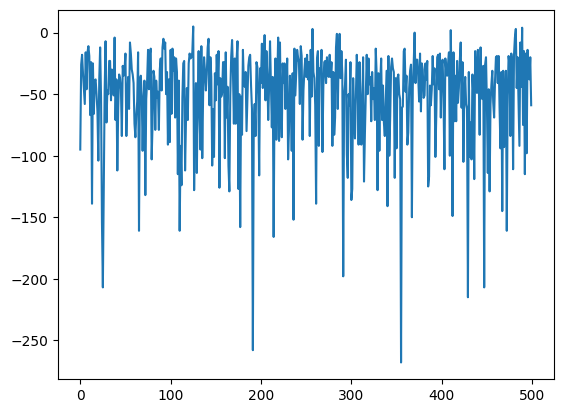

In [7]:
# Initialize environment and agent
environment = GridWorld()
random_agent = RandomAgent()

reward_per_episode = play(environment, random_agent, trials=500)

# Simple learning curve
plt.plot(reward_per_episode)

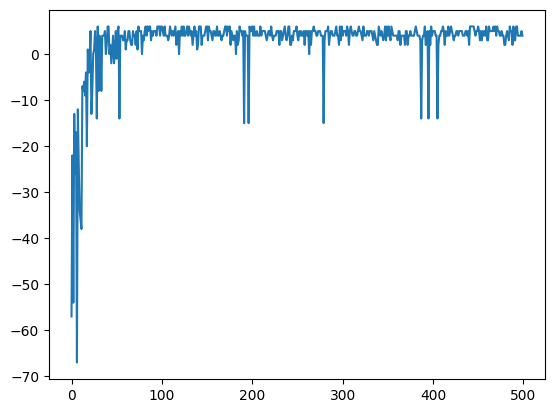

In [8]:
environment = GridWorld()
agentQ = Q_Agent(environment)

# Note the learn=True argument!
reward_per_episode = play(environment, agentQ, trials=500, learn=True)

# Simple learning curve
plt.plot(reward_per_episode)


In [9]:
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))


pretty(agentQ.q_table)

(0, 0)
	UP
		-0.4000000000000001
	DOWN
		-0.43307400181800004
	LEFT
		-0.4000000000000001
	RIGHT
		-0.34543900000000005
(0, 1)
	UP
		-0.2
	DOWN
		-0.16225074103585232
	LEFT
		-0.2
	RIGHT
		4.993664552930808
(0, 2)
	UP
		5.841838040283488
	DOWN
		4.871551538672635
	LEFT
		0.7612734588904311
	RIGHT
		9.999999999999995
(0, 3)
	UP
		0
	DOWN
		0
	LEFT
		0
	RIGHT
		0
(0, 4)
	UP
		0
	DOWN
		0
	LEFT
		7.94108867905351
	RIGHT
		0.46132155990000007
(1, 0)
	UP
		-0.5496880000000001
	DOWN
		-0.5732726731000001
	LEFT
		-0.4990000000000001
	RIGHT
		-0.5088726985568464
(1, 1)
	UP
		0.10195161699231203
	DOWN
		-0.42582000000000003
	LEFT
		-0.30100000000000005
	RIGHT
		4.373997335133923
(1, 2)
	UP
		8.999999999999982
	DOWN
		4.046066215191253
	LEFT
		0.9044214017998714
	RIGHT
		-6.12579511
(1, 3)
	UP
		0
	DOWN
		0
	LEFT
		0
	RIGHT
		0
(1, 4)
	UP
		3.71546094290401
	DOWN
		-0.11000000000000001
	LEFT
		-1.0
	RIGHT
		-0.19
(2, 0)
	UP
		-0.8480152579000001
	DOWN
		-0.9443734446522453
	LEFT
		-0.89810000000